# Segmenting cells automatically using U-net

In this notebook we take on the [data science bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018) challenge on Kaggle. The task is straight forward: teach a neural network to segment cells from the background from a set of labelled micrographs. The basic structure of such a network needs to satisfy the criteria: the number of input neurons must match the image dimensions, and so does the output layer. Thus we essentially are classifying every pixel in the input.

### Get the data
Follow the above link to download the data. Then unzip the `stage1_train` subfolder (we will simply ignore the others). Place it in the `data` directory.

### Deep learning libraries
Currently in Python there are two primary libraries for deep learning: Tensorflow and Pytorch. You have already seen a little Tensorflow (via the Keras API). Now will make use of Pytorch. Much of the code in the notebook will be very detailed, and we recommend not spending too much time reviewing these functions, as they mostly just are utility function

**credit to https://www.kaggle.com/arunmohan003/unet-starter-pytorch for the majority of the code**

## Note: Installing Pytorch

Like mentioned before, GPUs are needed to train deep learning models efficiently. Acknowledging that not everyone has that available. 

If you have a CUDA-compatible GPU and are interested, you can install the GPU version of pytorch. If you do *not* have a CUDA-compatible GPU, you can simply install the CPU version: `conda install pytorch torchvision torchaudio cpuonly -c pytorch`. 

If you chose to install use the GPU, you will have to install Cuda Toolkit and cudnn, which is a slightly lengthy procedure. Instructions for this can be found [here](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html). A recommended [tutorial is also available](https://www.tutorialspoint.com/cuda/cuda_installation.htm) which explains the steps needed to get started with GPU accelerated deep learning.


Installation instructions of Pytorch can be found [on the official website](https://pytorch.org/get-started/locally/). 

In [32]:
%reload_ext autoreload
%autoreload 2

In [33]:
import torch

In [35]:
torch.cuda.is_available()

True

In [36]:
torch.cuda.device_count()

1

In [ ]:
# set device to either CPU or GPU 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [37]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2
from albumentations.pytorch import ToTensor
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

In [41]:
1 if True else 2

1

In [ ]:
#zip_path = '/kaggle/input/data-science-bowl-2018/stage1_train.zip'
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall('/kaggle/working/data')

## Data loaders

Datasets are often very large when training deep learning algorithms, and loading everything into memory is not doable. Data loaders in Pytorch are special classes which contains the path to the data as well as functions for loading the data into memory. Here is a custom made loader for this particular dataset. 

Now we will load the data by using custom data loader from pytorch along with small preprocessing such as horizontal fliping and normalization.


In [12]:
def get_transforms(mean, std):
            list_transforms = []
            
            list_transforms.extend(
                    [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms


class Nuclei_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))

            mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')
    
            augmented = self.transforms(image=img, mask=mask)
            #augmented = [img] # fjern siden
            img = augmented['image']
            mask = augmented['mask']
            mask = mask[0].permute(2, 0, 1)
            return (img,mask) 


        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)
              
            return mask

In [13]:
base_dir = 'data/data-science-bowl-2018/stage1_train'
data = Nuclei_data(base_dir)

In [14]:
data.folders[1]
#data.get_mask(data.folders[1])

'003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1'

In [15]:
# print out some sample data
print(data.__len__())
data.__getitem__(0)

670


(tensor([[[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602,

In [17]:
for img,msk in data:
    print(img.shape)
    print(msk.shape)
    break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


In [18]:
# some utility functions
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

In [19]:
def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.title('image')
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.title('mask')
         plt.imshow(mask,cmap='gray')
    plt.show()

In [20]:
# splitting to trainset and validation set and loading the data with batch size of 10

trainset, valset = random_split(data, [580, 90])

train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10, shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

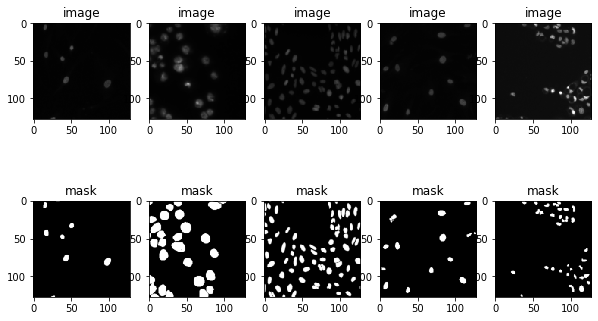

In [21]:
# we will try visualizing images and corresponding masks
plot_img(5)

## Building the network

In Pytorch, we implement models as a class, inheriting from `nn.Module`, which provides a set of standardized methods. Most importantly is it to implement a `forward` function which represents the forward pass of signals through the network.

In [22]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

        self.dblock5 = double_conv(256 + 512, 256)
        self.dblock6 = double_conv(128 + 256, 128)
        self.dblock7 = double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = torch.Sigmoid()

    def forward(self,x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)

        conv4 = self.dblock4(x)
        
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dblock7(x)

        out = self.last_layer(x)
        # out = self.sigmoid(x)
        return out

In [23]:
# loading the model to the GPU (or CPU)
model = Unet().to(device)
model

Unet(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2,


Loss function and IOU metric

This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models. Combined the two methods allows for some diversity in the loss, while benefitting from the stability of BCE.Similarly we use intersection over union as a metric


In [24]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou



def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou 

Now we will write some utility functions to save and load best model on training


In [25]:
#ref https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

# A training loop for the network

In [40]:
checkpoint_path = '/models/chkpoint_'
best_model_path = '/models/bestmodel.pt'
# decide upon a number of epochs before running
#epochs = 2

criterion = DiceBCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275

train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
         
    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
        image = image.to(device,dtype=torch.float)
        mask = mask.to(device,dtype=torch.float)
        
        pred_mask = model.forward(image) # forward propogation
        loss = criterion(pred_mask,mask)
        score = iou_batch(pred_mask,mask)
        optimizer.zero_grad() # setting gradient to zero
        loss.backward() # compute the gradients
        optimizer.step() # update the weights based on the gradients 
        running_train_loss.append(loss.item())
        running_train_score.append(score)

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    #save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ### TODO: save the model if validation loss has decreased
    #if epoch_val_loss <= valid_loss_min:
    #        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #        # save checkpoint as best model
    #        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
    #        valid_loss_min = epoch_val_loss
    #
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/2
Train loss : 0.3228942656825329 iou : 0.43190931416134126
Validation loss : 0.21457919312847984 iou : 0.6005823560527597
11m 31s
Epoch 2/2
Train loss : 0.25575337944359616 iou : 0.5393503526755651
Validation loss : 0.25380802816814846 iou : 0.5294673173077018
11m 29s


In [42]:
train_loss

[0.3228942656825329, 0.25575337944359616]

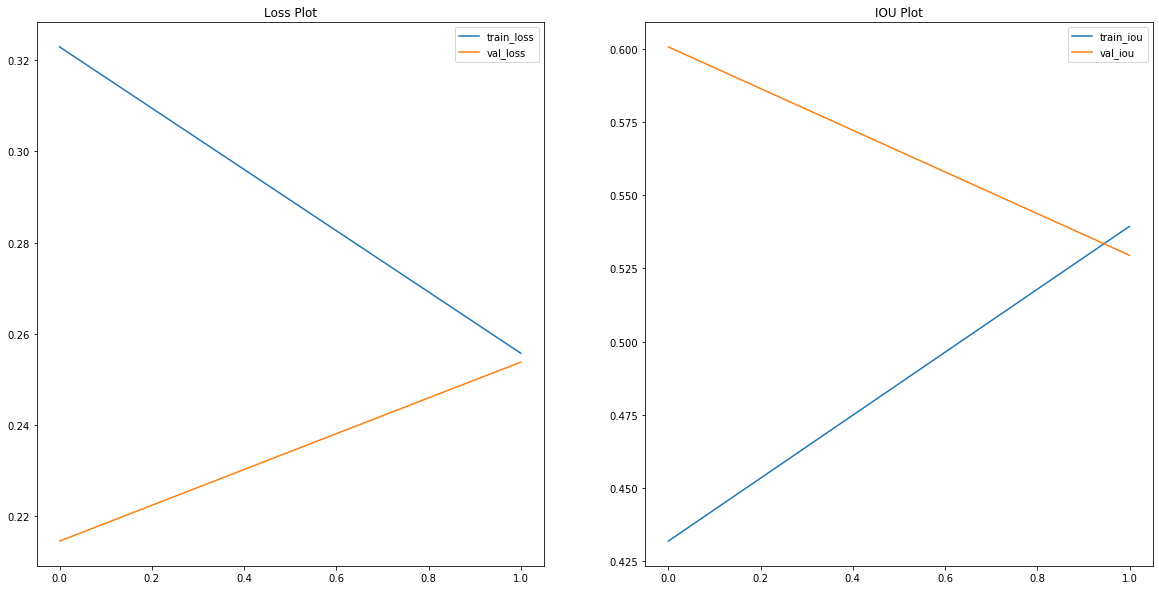

In [43]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

In [ ]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

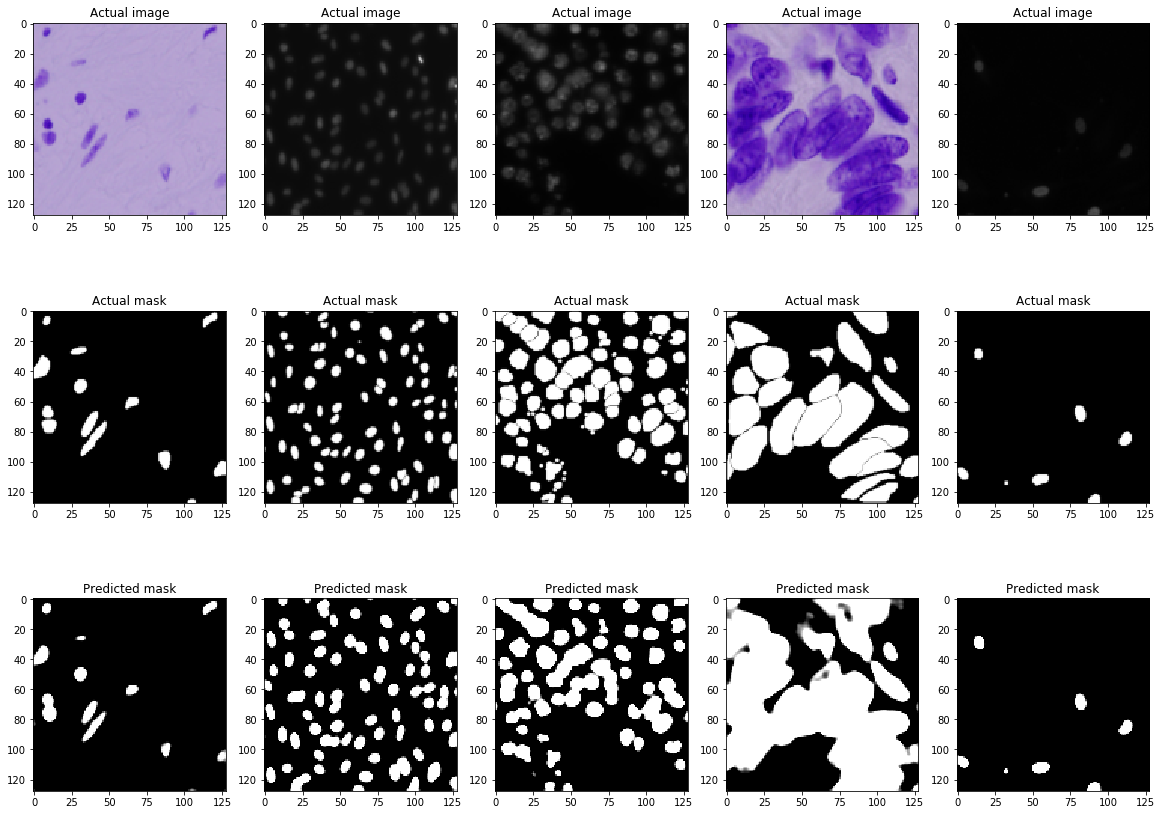

In [44]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()